# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services


## Index
    1   Packages Prerequisites
    2   Project Definition
    2.1 Project Overview
    2.2 Problem Statement
    2.3 Metrics
    3   Analysis
    3.1 Data Exploration and Visualization
    3.2 Data Preprocessing
    4   Problem 1: Customer Segmentation Report
    4.1 Implementation
    4.2 Results and Takeaway
    5   Problem 2: Supervised Learning Model
    5.1 Data Preprocessing
    5.2 Model implementation
    5.3 Train Results Evaluation and validation
    5.4 Tune Model
    5.5 Predict
    6   Conclusion
    6.1 Reflection and Improvement
    7.  Appendix (unused material from initial instruction)

## 1. Packages Prerequisites

Import the necessary packages for general usage and for machine learning

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import operator
# magic word for producing visualizations in notebook
%matplotlib inline

In [6]:
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

## 2. Project Definition

### 2.1 Project Overview

The main purpose of this project is to analyze demographics data for customers of a mail-order sales company in Germany, generalize the findings to general population and predict individuals who are more likely to convert into becoming customers for the company. The project is sponsored by the partners at Bertelsmann Arvato Analytics and the datasets are provided by the partners. 

There are 4 main datasets provided by the partners:
- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Besides, there are 2 additional info datasets, which provided the attributes info and value meanings of the above 4 datasets.

- `DIAS Attributes - Values 2017.xlsx`: Meanings of values for columns in the main datasets.
- `DIAS Information Levels - Attributes 2017.xlsx`: Description of columns in the main datasets.


### 2.2 Problem Statement

There are two major problems under this project:
    1. Analyze and identify the parts of population that best describe the core customer base of the company
    2. Predict individuals that are most likely to convert into becoming customers for the company

The approach to the first problem would be an unsupervised machine learning model that clusters the customers demographics data and the general population. After the clustering, the core customer base could be found through percentage of customers base in each cluster and the affinity to the general population could be found for the population in the same cluster. 

The approach to the second problem would be a supervised machine learning model that trains with the training set of demographics data for individuals who were targets of a marketing campaign and then tests with the test set. Multiple machine learning model would be used to find out which model would be best to use for the prediction before applying the model on the test set.

### 2.3 Metrics

The metrics for the first problem would be hard to define since the first problem is an unsupervised machine learning question. Thus, the metrics discussion will be focused on the second supervised machine learninhg model problem. The second problem is a classification problem with two labels, 0 meaning the customer didn't respond while 1 means the customer did respond. Through data exploration of the training set, I find the labels of the two classes in the training set is highly imbalanced. Therefore, accuracy is not a good metric for the problem. ROC-AUC will be a better metrics to evaluate the success of the models.

## 3. Analysis

### 3.1 Data Exploration and Visualization

First, I load the general population and customers demographic files and do some EDA on them.

In [8]:
# load in the data
# workspace
#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
# local
azdias = pd.read_csv('./Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('./Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


I also loaded in the other 2 info xlsx that provide extra insights to the demo data.

In [9]:
# load in attributes values and info
attributes_values = pd.read_excel('./DIAS Attributes - Values 2017.xlsx', header=1)
attributes_info = pd.read_excel('./DIAS Information Levels - Attributes 2017.xlsx', header=1)
attributes_values.reset_index(drop=True, inplace=True)
attributes_values.ffill(inplace=True)
attributes_info.reset_index(drop=True, inplace=True)
attributes_info['Information level'].ffill(inplace=True)

In [10]:
# Confirm the rows and columns count of the two dataset
print('General Population Shape: ', azdias.shape)
print('Customer Shape: ', customers.shape)

General Population Shape:  (891221, 366)
Customer Shape:  (191652, 369)


The azdias general population data is too large for workspace to digest, and the following data cleaning, dimensionality reduction and clustering would take too long too process. Thus, following recommendation from mentor on https://knowledge.udacity.com/questions/619345, I decided to sample 30% of the general population for this project.

In [11]:
azdias=azdias.sample(frac=0.3,replace=False,random_state=42)

In [12]:
# Confirm the rows and columns count of the two dataset
print('General Population Shape for Analysis: ', azdias.shape)
print('Customer Shape for Analysis: ', customers.shape)

General Population Shape for Analysis:  (267366, 366)
Customer Shape for Analysis:  (191652, 369)


In [13]:
# A glimpse of the two dataset
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
848815,956771,1,1.0,12.0,NaN,NaN,NaN,NaN,12.0,6.0,...,2.0,9.0,12.0,10.0,NaN,9.0,4.0,3,2,3
299816,536767,-1,1.0,0.0,NaN,NaN,NaN,NaN,21.0,1.0,...,1.0,2.0,3.0,3.0,3.0,8.0,3.0,1,2,2
570748,393990,-1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,...,1.0,8.0,9.0,6.0,6.0,9.0,7.0,1,1,1
354371,596074,-1,9.0,16.0,NaN,NaN,NaN,NaN,15.0,1.0,...,NaN,2.0,3.0,4.0,2.0,9.0,3.0,1,1,3
329018,586471,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,3


In [14]:
# A glimpse of the two dataset
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [15]:
# A glimpse of the numeric column
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,2.673660e+05,267366.000000,245257.000000,245257.000000,24323.000000,8733.000000,1843.000000,339.000000,188577.000000,239397.000000,...,230937.000000,244558.000000,244558.000000,244558.000000,235097.000000,245257.000000,239397.000000,267366.000000,267366.000000,267366.000000
mean,6.374045e+05,-0.357899,4.415719,10.878858,11.745097,13.341005,14.512208,15.112094,13.689533,8.241006,...,2.418777,6.002404,7.534650,5.949648,3.936043,7.905703,4.058814,3.362563,1.522692,2.774530
std,2.569691e+05,1.198645,3.639794,7.636284,4.091793,3.214868,2.674575,2.343151,5.091852,15.541676,...,1.165250,2.856726,3.249712,2.771444,1.966588,1.925207,1.951440,1.352473,0.499486,1.070791
min,1.916540e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.153542e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.370195e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.602215e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [16]:
# A glimpse of the numeric column
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [17]:
# A glimpse of the object column
azdias.select_dtypes('object').head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
848815,9B,9,51,D19_UNBEKANNT,1992-02-12 00:00:00,W
299816,4C,4.0,24.0,D19_BANKEN_DIREKT,1992-02-10 00:00:00,W
570748,4C,4,24,NaN,1994-08-30 00:00:00,W
354371,3A,3.0,23.0,D19_VERSICHERUNGEN,2005-10-11 00:00:00,W
329018,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# A glimpse of the object column
customers.select_dtypes('object').head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
0,1A,1.0,13.0,D19_UNBEKANNT,1992-02-12 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
1,NaN,NaN,NaN,D19_BANKEN_GROSS,NaN,NaN,FOOD,SINGLE_BUYER
2,5D,5.0,34.0,D19_UNBEKANNT,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
3,4C,4.0,24.0,D19_NAHRUNGSERGAENZUNG,1992-02-10 00:00:00,W,COSMETIC,MULTI_BUYER
4,7B,7.0,41.0,D19_SCHUHE,1992-02-12 00:00:00,W,FOOD,MULTI_BUYER


In [19]:
# From the glimpse of the data, I have found that most columns seem to have NaNs. 
# Thus, checking the NaNs for both datasets to evaluate the efforts needed for cleaning data
print((azdias.isna().sum()>0).sum(), "columns in general population have nan.")
print((azdias.isna().sum()==0).sum(), "columns in general population have no nan.")
print((customers.isna().sum()>0).sum(), "columns in customers have nan.")
print((customers.isna().sum()==0).sum(), "columns in customers have no nan.")

273 columns in general population have nan.
93 columns in general population have no nan.
273 columns in customers have nan.
96 columns in customers have no nan.


For the two datasets, around 75% of columns have NaNs. Next question is what percentages of the data are having NaNs. Depending on the percentage, I will need to decide how to work with the missing data.

In [20]:
# Finding out percentage of NaNs of each column
azdias_null = azdias.isnull().sum()
azdias_null_percent = azdias_null / len(azdias) * 100
customers_null = customers.isnull().sum()
customers_null_percent = customers_null / len(customers) * 100

<AxesSubplot:>

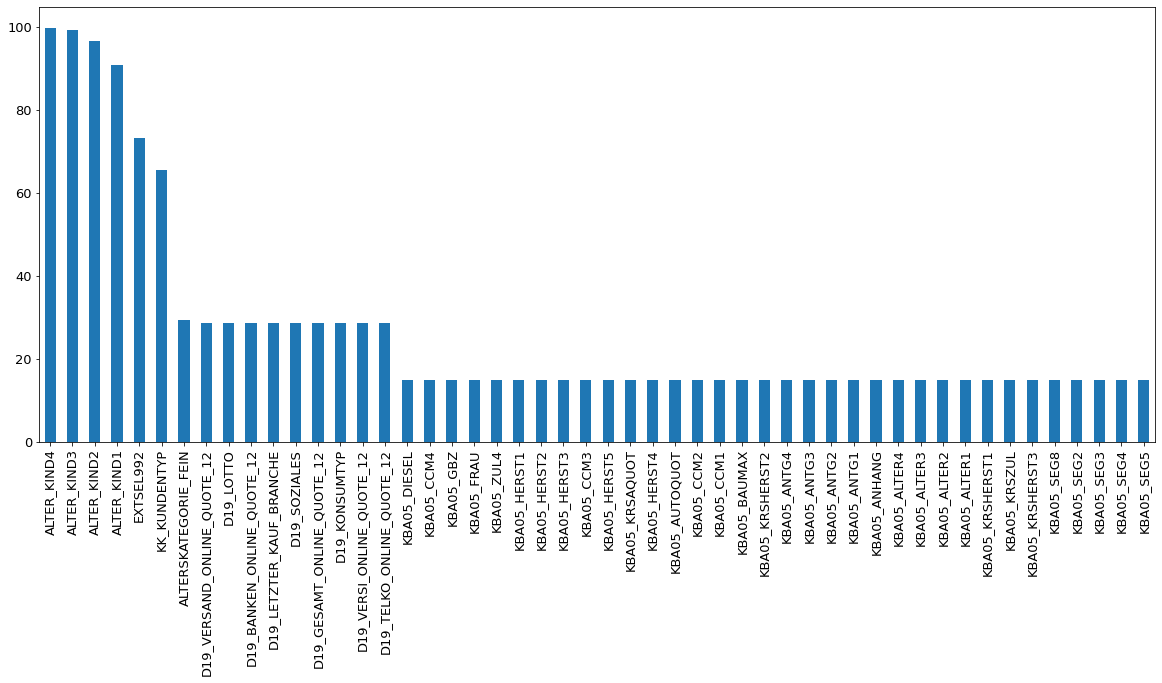

In [21]:
# Plot the graphs
(azdias_null_percent.sort_values(ascending=False)[:50].plot(kind='bar', figsize=(20,8), fontsize=13))  

<AxesSubplot:>

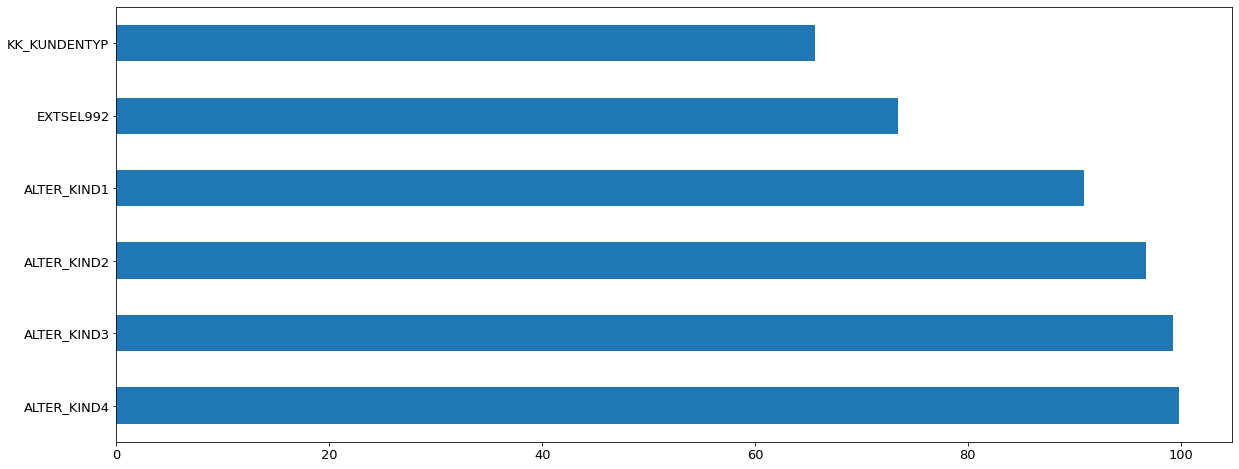

In [22]:
# Plot the several columns that have more than 50% missing values
azdias_null_percent[azdias_null_percent>50].\
    sort_values(ascending=False)[:50].plot(kind='barh', figsize=(20,8), fontsize=13)

<AxesSubplot:>

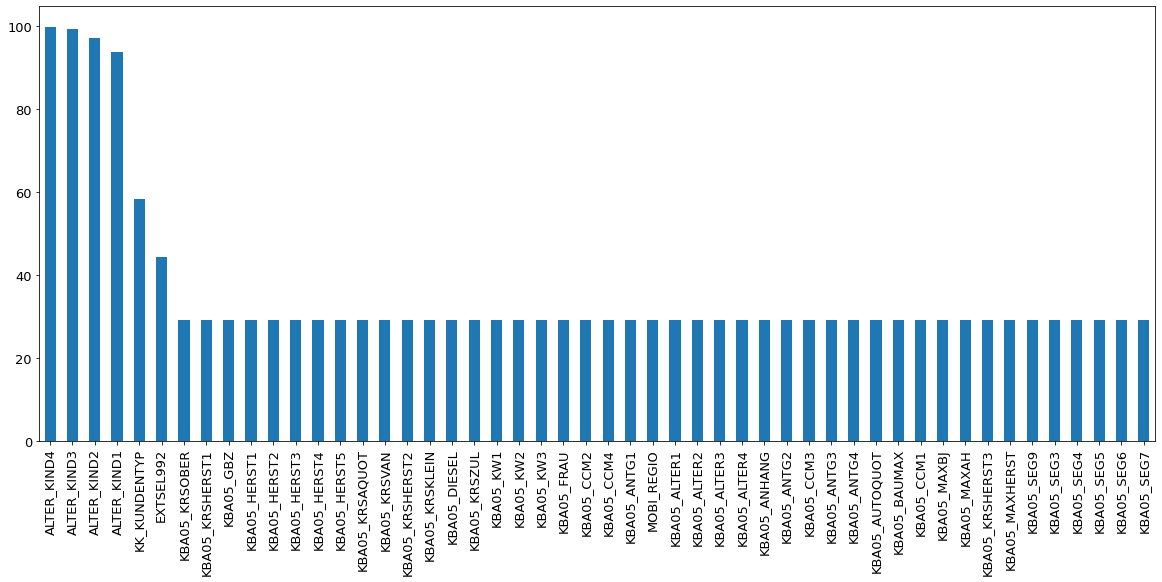

In [23]:
# Plot the graphs
(customers_null_percent.sort_values(ascending=False)[:50].plot(kind='bar', figsize=(20,8), fontsize=13))  

<AxesSubplot:>

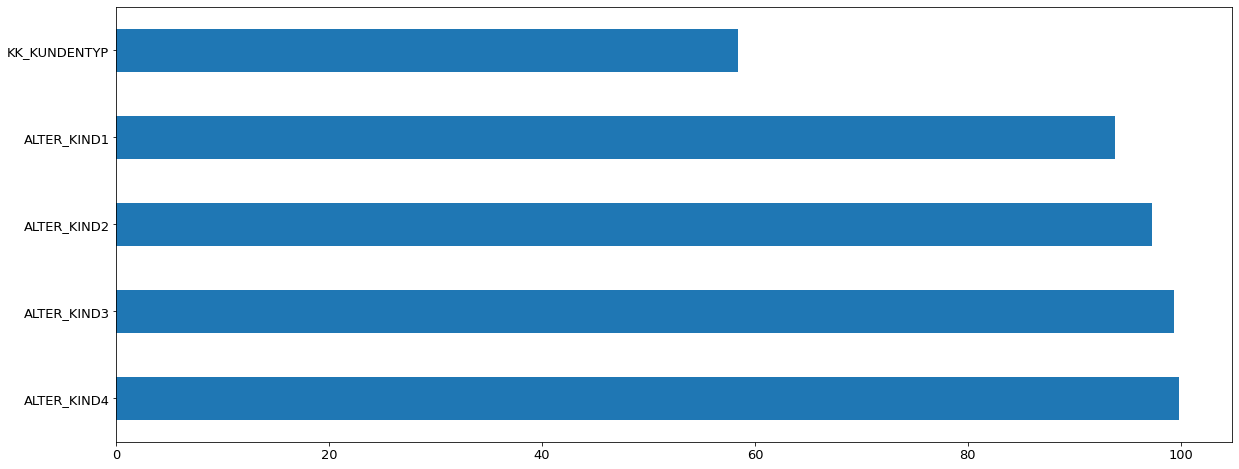

In [24]:
# Selective plotting the columns that have more than 50% missing values
customers_null_percent[customers_null_percent>50].\
    sort_values(ascending=False)[:50].plot(kind='barh', figsize=(20,8), fontsize=13)

From the analysis and data visualization above, I find out that there are 5-6 columns that are mostly missing for both datasets. Thus, these 6 columns should be considered to drop during the data preprocessing part.

### 3.2 Data Preprocessing

#### 3.2.1 Mixed types warning

The first section of data preprocessing is to solve the mixed types of dtypes warning of the two datasets.

In [25]:
warning_cols = list(azdias.columns[18:20])
warning_cols

['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']

In [26]:
attributes_values["Attribute"].unique()

array(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ALTER_HH', 'ANREDE_KZ',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'BALLRAUM', 'BIP_FLAG', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015',
       'CAMEO_DEUINTL_2015', 'CJT_GESAMTTYP', 'D19_BANKEN_ANZ_12',
       'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT_RZ',
       'D19_BANKEN_GROSS_RZ', 'D19_BANKEN_LOKAL_RZ',
       'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM',
       'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST_RZ',
       'D19_BEKLEIDUNG_GEH_RZ', 'D19_BEKLEIDUNG_REST_RZ',
       'D19_BILDUNG_RZ', 'D19_BIO_OEKO_RZ', 'D19_BUCH_RZ',
       'D19_DIGIT_SERV_RZ', 'D19_DROGERIEARTIKEL_RZ', 'D19_ENERGIE_RZ',
       'D19_FREIZEIT_RZ', 'D19_GARTEN_RZ', 'D19_GESAMT_ANZ_12',
       'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK_RZ',
       'D19_HAUS_DEKO_RZ', 'D19_KINDERARTIKEL_RZ', 'D19_K

The attribute names are different between dataset and attribute in attribute values. Thus, to look at the values meaning, I need to manually give the names.

In [27]:
attributes_values[attributes_values["Attribute"].isin(['CAMEO_DEUG_2015', 'CAMEO_DEUINTL_2015'])]

,Unnamed: 0,Attribute,Description,Value,Meaning
51,NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
52,NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,1,upper class
53,NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,2,upper middleclass
54,NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,3,established middleclasse
55,NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,4,consumption-oriented middleclass
56,NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,5,active middleclass
57,NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,6,low-consumption middleclass
58,NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,7,lower middleclass
59,NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,8,working class
60,NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,9,urban working class


In [28]:
# Find out the reason why these two columns have dtypes error
for col in warning_cols:
    print(col,azdias[col].unique())
    print(col,customers[col].unique())

CAMEO_DEUG_2015 ['9' 4.0 '4' 3.0 nan 9.0 '2' '8' 2.0 '1' '7' '5' 8.0 7.0 '3' '6' 6.0 5.0
 1.0 'X']
CAMEO_DEUG_2015 [1.0 nan 5.0 4.0 7.0 3.0 9.0 2.0 6.0 8.0 '6' '3' '8' '9' '2' '4' '1' '7'
 '5' 'X']
CAMEO_INTL_2015 ['51' 24.0 '24' 23.0 nan 51.0 '13' '55' 13.0 '15' '14' '12' '41' '34' '52'
 54.0 '25' '43' 14.0 22.0 '54' '22' 12.0 '35' 43.0 '44' 44.0 '23' 55.0
 25.0 41.0 '31' 45.0 32.0 '45' 15.0 34.0 33.0 35.0 52.0 '32' 31.0 'XX'
 '33']
CAMEO_INTL_2015 [13.0 nan 34.0 24.0 41.0 23.0 15.0 55.0 14.0 22.0 43.0 51.0 33.0 25.0 44.0
 54.0 32.0 12.0 35.0 31.0 45.0 52.0 '45' '25' '55' '51' '14' '54' '43'
 '22' '15' '24' '35' '23' '12' '44' '41' '52' '31' '13' '34' '32' '33'
 'XX']


From the print out, I find out that there is 'X' in the CAMEO_DEUG_2015 and 'XX' in the CAMEO_INTL_2015 column in both datasets. According to the value and meanings from the attribute list. Both should be changed to nan.

In [29]:
azdias[warning_cols[0]].replace('X', np.nan, inplace = True)
customers[warning_cols[0]].replace('X', np.nan, inplace = True)
azdias[warning_cols[1]].replace('XX', np.nan, inplace = True)
customers[warning_cols[1]].replace('XX', np.nan, inplace = True)

Then convert these two columns back to float.

In [30]:
def convert_object_to_float(df,col):
    '''
    DESC: Converts the data type from object to float according to the data frame and column list given as input.
    
    INPUT:
    df - Pandas DataFrame
    col - Column List
    
    OUTPUT:
    df - Pandas DataFrame
    '''
    for c in col:
        df[c] = df[c].astype(str).astype(float)
    
    return df

In [31]:
customers = convert_object_to_float(customers,warning_cols)
azdias = convert_object_to_float(azdias,warning_cols)

#### 3.2.2 Convert Unknown to NaNs

The second section is to align the values of unknown according to the attributes values and meanings. According to the value counts of meanings, I have seen a large amount of unknown, which has different values. Thus, I think I should convert them to NaN first and then align them with the same values.

In [32]:
attributes_values['Meaning'].value_counts()[:20]

unknown                            232
average                            162
low                                154
high                               154
very high                          142
very low                           139
none                               138
no transaction known                34
Prospects > 24 months               34
Buyer > 24 months                   34
Singlebuyer 13-24 months            34
Multi-/Doublebuyer 13-24 months     34
Singlebuyer 0-12 months             34
Multibuyer 0-12 months              34
Doublebuyer 0-12 months             34
no transactions known               22
very high affinity                  14
lowest affinity                     14
very low affinity                   14
low affinity                        14
Name: Meaning, dtype: int64

In [33]:
attributes_missing = attributes_values[attributes_values['Meaning'].isin(['unknown'])]
attributes_missing.head()

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
33,NaN,ANREDE_KZ,gender,"-1, 0",unknown
40,NaN,BALLRAUM,distance to next urban centre,-1,unknown
48,NaN,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown


In [34]:
def missing_dict(df):
    '''
    DESC: Generate a dictionary of key value pair, whose key is the attribute name
    and whose value is the values meaning unknown, so that I can use dictionary to
    map values from representing unknown to NaNs.
    
    INPUT:
    df - Pandas DataFrame 
    
    OUPUT:
    missing_dict - Dictionary
    '''

    unknown_values = []
    for val in df.Value:
        if isinstance(val, int):
            unknown_values.append([val])
        elif isinstance(val, str):
            split_list = val.split(',')
            int_list = [int(x) for x in split_list]
            unknown_values.append(int_list)

    unknown_dict = {}
    for attr, value_list in zip(df.Attribute, unknown_values):
    # During exploration, I found that the attribute name is different from the columns names in dataset
        if 'D19' in attr and '_RZ' in attr:
            attr = attr[:-3]
        
        unknown_dict[attr] = value_list
    
    # During data exploration, I found that these two columns have 0, which should be unknown as well
    unknown_dict['ALTERSKATEGORIE_FEIN'] = [0]
    unknown_dict['GEBURTSJAHR'] = [0]
    
    return unknown_dict

In [35]:
missing_dict = missing_dict(attributes_missing)
missing_dict

{'AGER_TYP': [-1],
 'ALTERSKATEGORIE_GROB': [-1, 0],
 'ANREDE_KZ': [-1, 0],
 'BALLRAUM': [-1],
 'BIP_FLAG': [-1],
 'CAMEO_DEUG_2015': [-1],
 'CAMEO_DEUINTL_2015': [-1],
 'CJT_GESAMTTYP': [0],
 'D19_KK_KUNDENTYP': [-1],
 'EWDICHTE': [-1],
 'FINANZTYP': [-1],
 'FINANZ_ANLEGER': [-1],
 'FINANZ_HAUSBAUER': [-1],
 'FINANZ_MINIMALIST': [-1],
 'FINANZ_SPARER': [-1],
 'FINANZ_UNAUFFAELLIGER': [-1],
 'FINANZ_VORSORGER': [-1],
 'GEBAEUDETYP': [-1, 0],
 'GEOSCORE_KLS7': [-1, 0],
 'HAUSHALTSSTRUKTUR': [-1, 0],
 'HEALTH_TYP': [-1],
 'HH_EINKOMMEN_SCORE': [-1, 0],
 'INNENSTADT': [-1],
 'KBA05_ALTER1': [-1, 9],
 'KBA05_ALTER2': [-1, 9],
 'KBA05_ALTER3': [-1, 9],
 'KBA05_ALTER4': [-1, 9],
 'KBA05_ANHANG': [-1, 9],
 'KBA05_ANTG1': [-1],
 'KBA05_ANTG2': [-1],
 'KBA05_ANTG3': [-1],
 'KBA05_ANTG4': [-1],
 'KBA05_AUTOQUOT': [-1, 9],
 'KBA05_BAUMAX': [-1, 0],
 'KBA05_CCM1': [-1, 9],
 'KBA05_CCM2': [-1, 9],
 'KBA05_CCM3': [-1, 9],
 'KBA05_CCM4': [-1, 9],
 'KBA05_DIESEL': [-1, 9],
 'KBA05_FRAU': [-1, 9],
 'KB

With the help of this dictionary, I can start converting all the values in this dictionary to NaNs to represent the unknown structure of the data.

In [36]:
def change_nan_value(df,missing_dict):
    '''
    DESC: Converts the values that represent Unknown in nature to NaNs to align the data
    
    INPUT:
    df - Pandas DataFrame
    missing_dict - Dictionary
    
    OUTPUT:
    df - Pandas Dataframe
    
    '''
    
    change_column = []
    for (key,value) in missing_dict.items():

        try:
            df[key].replace(missing_dict[key], np.nan, inplace = True)
            change_column.append(key)
        except:
            continue
            
    return df
    

In [37]:
customers = change_nan_value(customers,missing_dict)
azdias = change_nan_value(azdias,missing_dict)

#### 3.2.3 Convert Catgorical columns

The third step is to preprocess the categorical columns to see whether they should be encoded or dropped.

In [38]:
azdias_object_col = list(azdias.select_dtypes('object'))
customers_object_col = list(customers.select_dtypes('object'))
print('azdias object column values')
for col in azdias_object_col:
    print(col,azdias[col].unique())
print('customers object column values')
for col in customers_object_col:
    print(col,customers[col].unique())

azdias object column values
CAMEO_DEU_2015 ['9B' '4C' '3A' nan '9D' '2B' '8D' '4D' '1D' '2D' '2A' '7A' '5D' '8A' '9A'
 '7D' '3D' '6B' '3C' '4A' '8C' '5F' '6C' '7B' '3B' '9E' '4E' '5A' '4B'
 '7E' '5B' '5E' '1E' '1A' '8B' '9C' '2C' '5C' '1B' '7C' '6A' '6D' '6E'
 '1C' '6F' 'XX']
D19_LETZTER_KAUF_BRANCHE ['D19_UNBEKANNT' 'D19_BANKEN_DIREKT' nan 'D19_VERSICHERUNGEN'
 'D19_TELKO_REST' 'D19_SONSTIGE' 'D19_VOLLSORTIMENT' 'D19_BUCH_CD'
 'D19_VERSAND_REST' 'D19_DROGERIEARTIKEL' 'D19_BEKLEIDUNG_REST'
 'D19_SCHUHE' 'D19_BANKEN_LOKAL' 'D19_BEKLEIDUNG_GEH' 'D19_TECHNIK'
 'D19_WEIN_FEINKOST' 'D19_HAUS_DEKO' 'D19_TELKO_MOBILE' 'D19_FREIZEIT'
 'D19_RATGEBER' 'D19_HANDWERK' 'D19_LEBENSMITTEL' 'D19_BANKEN_REST'
 'D19_LOTTO' 'D19_ENERGIE' 'D19_REISEN' 'D19_KINDERARTIKEL'
 'D19_TIERARTIKEL' 'D19_BANKEN_GROSS' 'D19_NAHRUNGSERGAENZUNG'
 'D19_SAMMELARTIKEL' 'D19_GARTEN' 'D19_KOSMETIK' 'D19_DIGIT_SERV'
 'D19_BIO_OEKO' 'D19_BILDUNG']
EINGEFUEGT_AM ['1992-02-12 00:00:00' '1992-02-10 00:00:00' '1994-08-30 00:00:0

Product_group and customer_group are two extra columns exist in customers dataset, which will be removed to have aligned columns between azdias general population demographics and customer demographics.

CAMEO_DEU_2015, D19_LETZTER_KAUF_BRANCHE and EINGEFUEGT_AM include information that are too details for the clusters, thus needs to be dropped before modelling.

OST_WEST_KZ could be encoded.

In [39]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in cat_cols:
        try:
            df = pd.concat([df.drop(col,axis=1),pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)],axis=1)
        except:
            continue
    return df

In [40]:
customers = create_dummy_df(customers, ['OST_WEST_KZ'], False)
azdias = create_dummy_df(azdias, ['OST_WEST_KZ'], False)

#### 3.2.4 Drop columns

After encoding categorical values and transforming unknown representation of values to NaN, I need to consider what columns to drop. There are multiple categories that need to be considered:
    1. Extra columns from Customer data
    2. Categorical columns that are too detailed
    3. Index column
    4. Columns that have many missing or unknown values to be useful(threshold set to be 40%)

In [41]:
def drop_column(df,col):
    '''
    DESC: Removes columns from the input list from the dataset.
    
    INPUT:
    df - Pandas DataFrame
    col - list
    
    OUTPUT:
    df - Pandas DataFrame
    '''
    try:
        df = df.drop(col,axis=1)
    except:
        print("Can't drop the column!!")
    
    return df

Category 1: Extra columns from Customer data: 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'

In [42]:
drop_cat1 = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
customers = drop_column(customers,drop_cat1)

Category 2: Categorical columns that are too detailed 'CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM'

In [43]:
drop_cat2 = list(azdias.select_dtypes('object'))
drop_cat2

['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']

In [44]:
azdias = drop_column(azdias,drop_cat2)
customers = drop_column(customers,drop_cat2)

Category 3: Index column: 'LNR'

In [45]:
drop_cat3 = 'LNR'
azdias = drop_column(azdias,drop_cat3)
customers = drop_column(customers,drop_cat3)

Category 4: Columns that have many missing or unknown values to be useful(threshold set to be 40%): 'AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'EXTSEL992', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ'

In [46]:
def find_missing_col_percentage(df):
    df_null = df.isna().sum()
    df_null_perc = df_null/len(df)*100
    df_list = df_null_perc[df_null_perc>40]
    return df_list.index

In [47]:
drop_cat4 = find_missing_col_percentage(azdias)

In [48]:
drop_cat4

Index(['AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'EXTSEL992', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ'],
      dtype='object')

In [49]:
azdias = drop_column(azdias,drop_cat4)
customers = drop_column(customers,drop_cat4)

#### 3.2.5 Drop rows

Remove rows that have more than 50% of missing data

In [50]:
def remove_missing_rows(df, threshold):
    '''
    DESC: Removes missing data more than the threshold specified in the row.
    
    INPUT:
    df - Pandas DataFrame
    threshold - int
    
    OUTPUT:
    df - Pandas DataFrame
    '''
    total_rows = df.shape[0]
    
    df = df.dropna(thresh=df.shape[1]-threshold)
    
    removed_rows = total_rows - df.shape[0]
    
    df = df.reset_index().drop(['index'],axis=1)
    
    return df

In [51]:
customers = remove_missing_rows(customers, threshold=50)
azdias = remove_missing_rows(azdias, threshold=50)

#### 3.2.6 Impute missing values

Impute missing values

In [52]:
def fill_missing_value(df,missing_value = np.nan,strategy = 'most_frequent'):
    '''
    DESC: Fills the missing data in the Data Set according to the specified strategy.
    INPUT:
    df - Pandas DataFrame
    missing_value - string
    strategy - string
    
    OUTPUT:
    df - Pandas DataFrame
    '''
    col = df.columns
    
    imputer = SimpleImputer(missing_values=missing_value, strategy=strategy)
    df = imputer.fit_transform(df)
    
    return pd.DataFrame(df,columns = col)

In [53]:
customers = fill_missing_value(customers)
azdias = fill_missing_value(azdias)

In [54]:
print('Number of missing data in Azdias dataset:',np.sum(azdias.isna().sum()))
print('Number of missing data in Customers dataset:',np.sum(customers.isna().sum()))

Number of missing data in Azdias dataset: 0
Number of missing data in Customers dataset: 0


#### 3.2.7 Normalize the data

Normailizing data

In [181]:
def normalize_data(df1,df2,one_scale='True'):
    '''
    DESC: Standardizes the given dataset.
    
    INPUT:
    df1 - Pandas DataFrame
    df2 - Pandas DataFrame
    
    OUTPUT: 
    df1 - Pandas DataFrame
    df2 - Pandas DataFrame
    scale - trained model
    '''

    scale = StandardScaler(copy=False)

    df1[df1.columns] = scale.fit_transform(df1)
    if one_scale==True:
        df2[df1.columns] = scale.transform(df2)
        return df1, df2, scale
    else:
        return df1,scale

In [56]:
azdias, customers, scale = normalize_data(azdias, customers)

In [57]:
print('After data cleaning:')
print("General Population Shape: ",azdias.shape)
print("Customers Shape: ",customers.shape)

After data cleaning:
General Population Shape:  (221105, 352)
Customers Shape:  (134246, 352)


Save Copies of csv files in case workspace lost connections.

In [108]:
#azdias.to_csv('azdias.csv.', index=False)
#customers.to_csv('customers.csv', index=False)

## 4 Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 4.1 Implementation

#### 4.1.1 Dimension Reduction

Even after data cleaning, there are 352 columns in the original dataset, which could bring issues when applying unsupervised machine learning model to create clusters. Thus, the first step take for customer segmentation report is to conduct a dimensionality reduction by PCA.

In [58]:
def perform_pca(df, n_components=None):
    """
    DESC: Perform pca on dataframe
    
    INPUT:
    df - Pandas DataFrame
    n_components -  integer
    
    OUTPUT:
    df_transformed - Pandas DataFrame
    pca - PCA object
    
    """
    pca = PCA(n_components)
    pca.fit(df)
    df_transformed = pca.transform(df)
    
    return df_transformed, pca

In [59]:
def plot_pca_exp_variance(pca, figsize=(8,10)):
    """
    DESC: Plot Explained Variance vs Number of components
    
    INPUT:
    pca - PCA object
    
    OUTPUT:
    None
    
    Print graph
    """   
    
    azdias_variance = np.cumsum(pca_azdias.explained_variance_ratio_)
    y_label = "Explained Variance(%)"
        
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(211)
    ax.plot(azdias_variance)
    
    
    
    #plt.axvline(x=160, ymax=azdias_variance[160], color='b')
    #print(azdias_variance[160])
    
    ax.set_xlabel("No. of components")
    ax.set_ylabel(y_label)
    ax.set_title("Azdias - PCA Explained Variance vs Number of Components")
    ax.grid()
    plt.show()

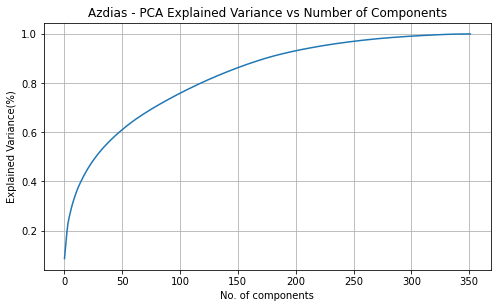

In [60]:
azdias_transformed, pca_azdias = perform_pca(azdias, None)
plot_pca_exp_variance(pca_azdias, figsize=(8,10))

From above graph and the cumulative sum calculation, I find the 90% threshold and use the number of components to rerun PCA on azdias general population demo and then apply the pca on customers demo. 

In [61]:
# find 90% threshold
np.cumsum(pca_azdias.explained_variance_ratio_)[174]

0.9010769244944802

In [62]:
azdias_pca, pca  = perform_pca(azdias,175)
customers_pca = pca.transform(customers)

In [63]:
def interpret_pca(df, pca, i):
    '''
    DESC: Creates graph to discuss desired Principial Component.
    
    INPUT:
    df - Pandas DataFrame
    pca - trained model
    i - int
    
    OUTPUT:
    None
    '''
    feature_weights = dict(zip(df.columns.values, pca.components_[i]))
    sorted_feature_weights = sorted(feature_weights.items(), key=operator.itemgetter(1), reverse=True)
    
    features = pd.DataFrame(sorted_feature_weights).iloc[np.r_[:3,  -3, -2, -1],:]
    feature_names = features[0].values
    weights = features[1].values

    fig = plt.figure(figsize=(10, 5))
    sns.set()

    ax = sns.barplot(x=weights, y=feature_names)
    ax.set(xlabel="Weight", ylabel="Attribute", title=f'{i+1}.Principal Component')

To interpret the PCA generated, the below three are the 3 principal components and the three attributes having most positive weights in each of the component and the three attributed having the most negative weights in each of the component.

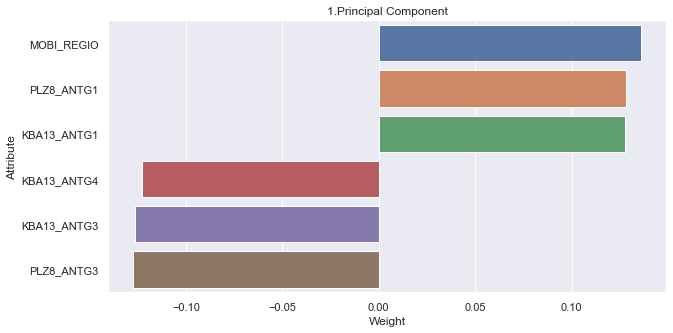

In [64]:
interpret_pca(azdias, pca, 0)

Highest:
1. MOBI_REGIO - moving pattern (the higher, the less population moves)
2. PLZ8_ANTG1 - number of 1-2 family houses in the sub_postcode
3. KBA13_ANTG1 - number of 1-2 family houses in the cell

Lowest:
1. PLZ8_ANTG3 - number of 6-10 family houses in the sub_postcode
2. KBA13_ANTG3 - number of 6-10 family houses in the cell
3. KBA13_ANTG4 - number of >10 family houses in the cell

According to the weights, the first principal component is highly correlated to the living stability of the population and the neighborhood of the population.

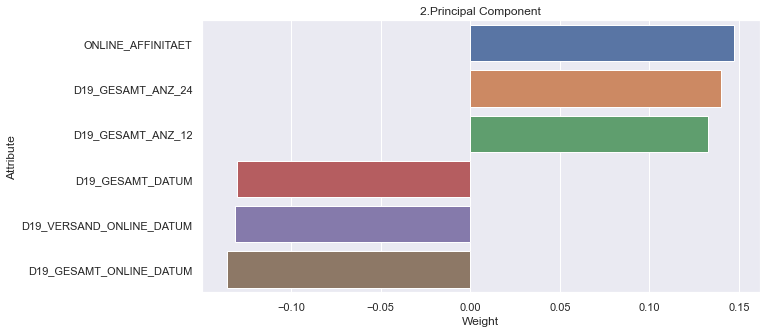

In [65]:
interpret_pca(azdias, pca, 1)

Highest:
1. ONLINE_AFFINITAET - online affinity
2. D19_GESAMT_ANZ_24 - transaction activity TOTAL POOL in the last 24 months 
3. D19_GESAMT_ANZ_12 - transaction activity TOTAL POOL in the last 12 months 

Lowest:
1. D19_GESAMT_ONLINE_DATUM - actuality of the last transaction with the complete file ONLINE
2. D19_VERSAND_ONLINE_DATUM - actuality of the last transaction for the segment mail-order ONLINE
3. D19_GESAMT_DATUM - actuality of the last transaction with the complete file TOTAL

According to the weights, the second principal component is highly correlated to the transactions that population made.

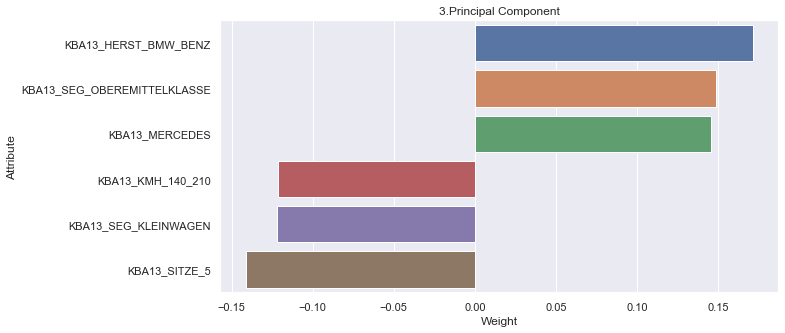

In [66]:
interpret_pca(azdias, pca, 2)

Highest:

    1. KBA13_HERST_BMW_BENZ - online affinity
    2. KBA13_SEG_OBEREMITTELKLASSE - share of upper middle class cars and upper class cars
    3. KBA13_MERCEDES - share of MERCEDES within the sub_postcode
Lowest:

    1. KBA13_SITZE_5 - number of cars with 5 seats in the sub_postcode
    2. KBA13_SEG_KLEINWAGEN - share of very small cars (Ford Ka etc.) in the sub_postcode
    3. KBA13_KMH_140_210 - share of cars with max speed between 140 and 210 km/h within the sub_postcode
According to the weights, the third principal component is highly correlated to car types each population has.

#### 4.1.2 Kmeans Cluster

After dimensionality reduction, I will then use Kmeans clustering method to create clusters for azdias general population and then apply the same kmeans cluster to the customers. Before doing that, I need to first find the best K to use to identify how many clusters to apply by elbow method.

In [67]:
wcss = []
for i in range(2,20):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(azdias_pca)
    wcss.append(kmeans.inertia_)
    print(i,'clusters run completed')

2 clusters run completed
3 clusters run completed
4 clusters run completed
5 clusters run completed
6 clusters run completed
7 clusters run completed
8 clusters run completed
9 clusters run completed
10 clusters run completed
11 clusters run completed
12 clusters run completed
13 clusters run completed
14 clusters run completed
15 clusters run completed
16 clusters run completed
17 clusters run completed
18 clusters run completed
19 clusters run completed


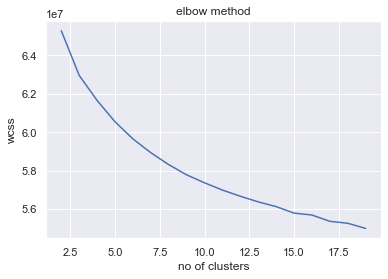

In [68]:
plt.plot(range(2,20), wcss)
plt.title("elbow method")
plt.xlabel("no of clusters")
plt.ylabel("wcss")
plt.show()

The graph doesn't show a clear elbow, I will arbitrarily choose 8 as cluster number.

In [69]:
kmeans = KMeans(init="k-means++", n_clusters=8, max_iter=300, random_state=42)
azdias_pred = kmeans.fit_predict(azdias_pca)
customers_pred = kmeans.predict(customers_pca)

### 4.2 Results and Takeaway

Create the table and graph for general population and customer proportion of each cluster.

In [70]:
azdias_clusters = pd.Series(azdias_pred)
customers_clusters = pd.Series(customers_pred)

In [71]:
cluster_info = pd.DataFrame([])
cluster_info["Population"] = azdias_clusters.value_counts().sort_index()
cluster_info["Customers"] = customers_clusters.value_counts().sort_index()
cluster_info.reset_index(inplace=True)
cluster_info.rename(columns={"index":"Cluster"}, inplace=True)
cluster_info["Pop_proportion"] = (cluster_info["Population"]/cluster_info["Population"].sum()*100).round(2)
cluster_info["Customer_proportion"] = (cluster_info["Customers"]/cluster_info["Customers"].sum()*100).round(2)
cluster_info['difference'] = cluster_info["Customer_proportion"] - cluster_info["Pop_proportion"]
cluster_info

,Cluster,Population,Customers,Pop_proportion,Customer_proportion,difference
0,0,19508,4161,8.82,3.10,-5.72
1,1,27216,2325,12.31,1.73,-10.58
2,2,28833,16080,13.04,11.98,-1.06
3,3,34731,38126,15.71,28.40,12.69
4,4,19741,3198,8.93,2.38,-6.55
5,5,21713,31073,9.82,23.15,13.33
6,6,35257,38088,15.95,28.37,12.42
7,7,34106,1195,15.43,0.89,-14.54


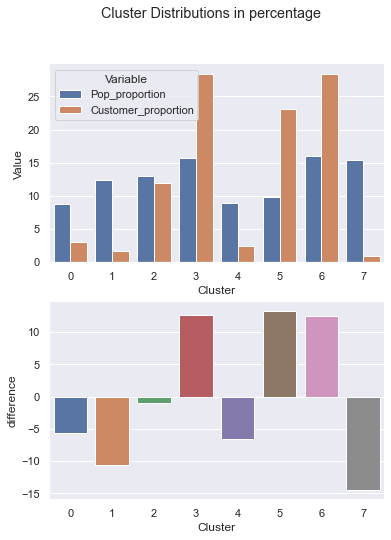

In [72]:
#fig, ax =plt.subplots(figsize=(12, 5))
fig, ax =plt.subplots(2,1, figsize=(6, 8))

fig.suptitle("Cluster Distributions in percentage")
#fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#fig.show()

data = cluster_info.melt(id_vars='Cluster').rename(columns=str.title)
data = data[data.Variable.str.contains('proportion')]


sns.barplot(x='Cluster', y='Value', hue='Variable', data=data, ax=ax[0])
sns.barplot(x='Cluster', y='difference', data=cluster_info, ax=ax[1])
sns.despine(fig)

From the above graphs, I can see 3 clusters have a high proportion of core customers(due to randomization nature of kmeans, the actual cluster number could change, but the general proportion shouldn't). Below is showing the cluster centers of the 3 clusters having high proportion of customers. The common point of the three clusters are the fairly large positive weight for the first principle components. This means the neighborhood the living stability will be very important to identify the core customers of the business.

In [73]:
kmeans.cluster_centers_[3][:5]

array([ 3.64200939, -4.00584838, -3.08661467, -0.39326418, -0.51156951])

In [74]:
kmeans.cluster_centers_[5][:5]

array([ 1.80587994, -4.30243672,  5.53651726,  1.63761567,  1.23781807])

In [75]:
kmeans.cluster_centers_[6][:5]

array([ 7.71610973,  3.41880814,  0.19889676,  0.84458177, -0.35490058])

## 5 Problem 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### 5.1 Data Preprocessing

### 5.1.1 Data Exploration

In [76]:
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train = pd.read_csv('./Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [77]:
mailout_train.shape

(42962, 367)

In [78]:
mailout_train.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,42962.000000,42962.000000,35993.000000,35993.000000,1988.000000,756.000000,174.000000,41.000000,34807.000000,35185.000000,...,35695.000000,35695.000000,35695.000000,33284.000000,35993.000000,35185.000000,42962.000000,42962.000000,42962.000000,42962.000000
mean,42803.120129,0.542922,1.525241,10.285556,12.606137,13.783069,14.655172,14.195122,9.855058,6.706096,...,4.318644,4.505953,3.116963,4.488403,8.729947,4.059685,2.804199,0.012383,1.595084,3.213910
std,24778.339984,1.412924,1.741500,6.082610,3.924976,3.065817,2.615329,3.034959,4.373539,15.151790,...,3.165199,3.289502,2.534331,1.889573,1.010545,2.046697,1.121585,0.110589,0.490881,1.067475
min,1.000000,-1.000000,1.000000,0.000000,2.000000,5.000000,6.000000,6.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,21284.250000,-1.000000,1.000000,8.000000,9.000000,12.000000,13.000000,13.000000,8.000000,1.000000,...,1.000000,2.000000,1.000000,3.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
50%,42710.000000,1.000000,1.000000,10.000000,13.000000,14.000000,15.000000,15.000000,10.000000,2.000000,...,3.000000,4.000000,2.000000,6.000000,9.000000,3.000000,3.000000,0.000000,2.000000,4.000000
75%,64340.500000,2.000000,1.000000,15.000000,16.000000,16.000000,17.000000,17.000000,13.000000,7.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,7.000000,3.000000,0.000000,2.000000,4.000000
max,85795.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,438.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [79]:
mailout_train.RESPONSE.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

From the response column, the response is very imbalanced. Thus, the accuracy metrics would not be a suitable metric to evaluate results. ROC-AUC would be better to use. 

### 5.1.2 Data cleaning

According to the data cleaning steps in section 3.2, following steps will be taken to clean the data.
1. Remove LNR (index) and Response (target variable) from dataset
2. Fix the mixed types error columns
3. Convert value represnting unknown to NaNs
4. Drop three categorical columns
5. Encode the last categorical column
6. Drop the columns that dropped in section 3.2
7. Fill missing data

In [138]:
def clean_data(df,df2,mode='train'):
    '''
    DESC: Returns the cleaned training data, index column and response column.
    INPUT:
    df - Pandas DataFrame
    df2 - Pandas DataFrame
    
    OUTPUT:
    df - Pandas DataFrame
    LNR_df - List
    RESPONSE_df - List
    '''
    
    LNR_df = df['LNR']
    if mode=='train':
        
        RESPONSE_df = df['RESPONSE']
        df = df.drop(['LNR','RESPONSE'],axis=1)
    else:
        df = df.drop(['LNR'], axis = 1)
    
    warning_cols = ['CAMEO_DEUG_2015','CAMEO_INTL_2015']
    df['CAMEO_DEUG_2015'].replace('X', np.nan, inplace = True)
    df['CAMEO_INTL_2015'].replace('XX', np.nan, inplace = True)

    df = convert_object_to_float(df,warning_cols)

    df = change_nan_value(df,missing_dict)

    categorical_drop_cols = ['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']

    obj_col_df = ['OST_WEST_KZ']
    
    df = create_dummy_df(df, obj_col_df, False)
    
    df_missing_columns = [col for col in df.columns if col not in df2.columns]

    df = drop_column(df,df_missing_columns)
    
    df = fill_missing_value(df)
    if mode=="train":
        return df, LNR_df, RESPONSE_df
    else:
        return df, LNR_df

In [153]:
mailout_train_clean,mailout_train_LNR,mailout_train_RESPONSE = clean_data(mailout_train,azdias)

In [182]:
mailout_train_clean.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,OST_WEST_KZ_W
0,-0.274048,-0.091614,-0.896557,0.671637,-0.116979,-0.204857,-0.656284,0.585171,-0.083831,-0.220509,...,0.395528,-0.584315,-0.720097,0.640850,0.2432,-0.457589,0.174577,0.824885,0.736410,0.778419
1,1.594293,0.650673,0.945558,-0.336522,-0.116979,-0.204857,0.113910,-0.329256,-0.083831,-1.214166,...,-0.877594,-0.584315,-0.720097,-0.559385,0.2432,1.651457,-1.608634,0.824885,-0.200391,0.778419
2,-0.274048,0.056844,-1.264980,-0.408533,-0.116979,-0.204857,-1.426478,-0.329256,-0.083831,0.773148,...,0.713809,0.026598,-0.310691,0.640850,0.2432,-0.984851,0.174577,-1.212290,0.736410,-1.284655
3,-0.274048,-0.388528,-1.633403,-0.120488,-0.116979,-0.204857,0.113910,-0.100649,-0.083831,0.773148,...,1.350369,2.164794,3.373970,0.640850,0.2432,-1.512113,0.174577,0.824885,0.736410,0.778419
4,-0.274048,0.056844,-0.528134,3.408069,-0.116979,-0.204857,-0.656284,2.947442,-0.083831,-0.220509,...,-0.559313,-0.584315,-0.720097,0.640850,0.2432,-0.457589,0.174577,-1.212290,-0.200391,0.778419


In [184]:
clean_mailout_train.describe()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,OST_WEST_KZ_W
count,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,...,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04
mean,-3.169780e-15,-7.818128e-16,-2.037159e-15,4.559145e-16,1.171140e-15,-2.080092e-15,-3.957673e-16,2.732996e-16,7.618118e-16,-7.625644e-17,...,-1.119702e-15,5.847884e-16,1.072938e-15,1.368529e-15,2.045402e-15,5.423042e-16,2.240762e-15,-4.329048e-17,-7.870174e-16,3.419462e-16
std,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,...,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00
min,-2.740484e-01,-1.279272e+00,-3.107096e+00,-4.085332e-01,-1.169788e-01,-2.048570e-01,-1.426478e+00,-4.054585e-01,-8.383054e-02,-2.207823e+00,...,-8.775938e-01,-8.897715e-01,-7.200974e-01,-2.359738e+00,-8.356283e+00,-2.039374e+00,-1.608634e+00,-1.212290e+00,-2.073993e+00,-1.284655e+00
25%,-2.740484e-01,-1.279272e+00,-5.281342e-01,-3.365218e-01,-1.169788e-01,-2.048570e-01,-6.562839e-01,-3.292562e-01,-8.383054e-02,-2.205094e-01,...,-8.775938e-01,-8.897715e-01,-7.200974e-01,-5.593854e-01,2.432003e-01,-4.575893e-01,1.745772e-01,-1.212290e+00,-2.003911e-01,-1.284655e+00
50%,-2.740484e-01,5.684379e-02,-5.281342e-01,-3.365218e-01,-1.169788e-01,-2.048570e-01,-6.562839e-01,-3.292562e-01,-8.383054e-02,7.731476e-01,...,-5.593134e-01,-2.788583e-01,-3.106906e-01,6.408501e-01,2.432003e-01,-4.575893e-01,1.745772e-01,8.248848e-01,7.364100e-01,7.784189e-01
75%,-2.740484e-01,6.506731e-01,5.771350e-01,-4.847635e-02,-1.169788e-01,-2.048570e-01,1.139103e-01,-2.444709e-02,-8.383054e-02,7.731476e-01,...,7.138085e-01,6.375114e-01,5.081230e-01,6.408501e-01,2.432003e-01,5.969341e-01,1.745772e-01,8.248848e-01,7.364100e-01,7.784189e-01
max,4.708196e+00,1.838332e+00,5.366635e+00,3.113245e+01,5.828676e+01,1.628169e+01,1.705818e+01,2.771318e+01,2.079459e+01,5.741433e+00,...,2.305211e+00,2.775707e+00,3.373970e+00,6.408501e-01,2.432003e-01,2.178719e+00,2.849394e+00,8.248848e-01,5.420416e+00,7.784189e-01


In [155]:
clean_mailout_train,scale= normalize_data(mailout_train_clean,mailout_train_clean,False)

### 5.2 Implementation

The model and comparison will be done in two fashion, one with the normalized data, the other one with pca transformed data. 

Create the train and validation set for the data

In [84]:
X_train, X_val, y_train, y_val = train_test_split(clean_mailout_train, mailout_train_RESPONSE, 
                                                  stratify=mailout_train_RESPONSE, 
                                                  test_size=0.2, random_state=42)

In [85]:
def train_and_predict(model, X_train, y_train, X_test, y_test):
    """
    DESC: Fit a model on X_train, y_train and predict on X_text, y_test 
        Calculate AUROC on predictions made on test data
    
    INPUT:
    model - model object
    X_train - Pandas DataFrame
    y_train - Series
    X_test - Pandas DataFrame
    y_test - Series
    
    OUTPUT:
    roc - numeric   
    """

    model = model.fit(X_train, y_train)
    train_roc = roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
    test_roc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    
    return train_roc, test_roc

Set up the models for comparison

In [86]:
models = [("LogisticRegression", LogisticRegression()),
         ("DecisionTreeClassifier", DecisionTreeClassifier()),
         ("RandomForestClassifier", RandomForestClassifier()),
         ("GradientBoostingClassifier", GradientBoostingClassifier()),
         ("AdaBoostClassifier", AdaBoostClassifier())]

In [87]:
results = {"Model":[],
          "train_AUCROC_score":[],
          "test_AUCROC_score":[]
          }

for name, model in models:
    train_roc, test_roc = train_and_predict(model, X_train, y_train, X_val, y_val)
    results["Model"].append(name)
    results["train_AUCROC_score"].append(train_roc)
    results["test_AUCROC_score"].append(test_roc)
   

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [88]:
results = pd.DataFrame.from_dict(results, orient='index').transpose()
results

,Model,train_AUCROC_score,test_AUCROC_score
0,LogisticRegression,0.738552,0.636524
1,DecisionTreeClassifier,0.994097,0.509069
2,RandomForestClassifier,0.965167,0.585205
3,GradientBoostingClassifier,0.909425,0.770569
4,AdaBoostClassifier,0.841772,0.739023


PCA transformed data train

In [89]:
mailout_train_pca = pca.transform(clean_mailout_train)

X_train_pca, X_val_pca, y_train_pca, y_val_pca = train_test_split(
    mailout_train_pca, mailout_train_RESPONSE, 
    stratify=mailout_train_RESPONSE, test_size=0.2, random_state=42)

In [90]:
results_pca = {"Model":[],
          "train_AUCROC_score":[],
          "test_AUCROC_score":[]
          }

for name, model in models:
    train_roc, test_roc = train_and_predict(model, X_train_pca, y_train_pca, X_val_pca, y_val_pca)
    results_pca["Model"].append(name)
    results_pca["train_AUCROC_score"].append(train_roc)
    results_pca["test_AUCROC_score"].append(test_roc)
results_pca = pd.DataFrame.from_dict(results_pca, orient='index').transpose()
results_pca

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model,train_AUCROC_score,test_AUCROC_score
0,LogisticRegression,0.69573,0.612991
1,DecisionTreeClassifier,0.994097,0.508599
2,RandomForestClassifier,0.965049,0.499892
3,GradientBoostingClassifier,0.904983,0.570298
4,AdaBoostClassifier,0.794395,0.55039


In [91]:
results_all = results.merge(results_pca, left_on='Model', right_on='Model', how='left')
newnames = ['Model', 'train_AUCROC_score','test_AUCROC_score','train_AUCROC_score_pca','test_AUCROC_score_pca']
results_all.columns =  newnames
results_all

,Model,train_AUCROC_score,test_AUCROC_score,train_AUCROC_score_pca,test_AUCROC_score_pca
0,LogisticRegression,0.738552,0.636524,0.69573,0.612991
1,DecisionTreeClassifier,0.994097,0.509069,0.994097,0.508599
2,RandomForestClassifier,0.965167,0.585205,0.965049,0.499892
3,GradientBoostingClassifier,0.909425,0.770569,0.904983,0.570298
4,AdaBoostClassifier,0.841772,0.739023,0.794395,0.55039


### 5.3 Train Results Evaluation and validation

From the train and test ROC AUC scores, the best of all is Gradient Boosting Classifier with no PCA applied. Thus, I will choose this setup. But I still see train score to be much higher than the test score under Gradient Boosting classifier, meaning that the model could still be likely overfitting. Thus, I will do more tuning in next section.

### 5.4 Tune model

Use grid search to find the best parameters for the model wih cross validation results

In [98]:
GBC_classifier = GradientBoostingClassifier(random_state=42)
parameters = {'learning_rate':[0.001,0.01,0.1,1],
             'n_estimators' : [50,100,200,300],
             'max_depth':[3,5,7]}
GBC_obj = GridSearchCV(GBC_classifier, 
                             parameters, 
                             scoring = "roc_auc", 
                             cv = 5,
                             verbose=3
                      )
GBC_fit = GBC_obj.fit(clean_mailout_train, mailout_train_RESPONSE)
GBC_opt = GBC_fit.best_estimator_
GBC_fit.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ..learning_rate=0.001, max_depth=3, n_estimators=50; total time=  18.9s
[CV] END ..learning_rate=0.001, max_depth=3, n_estimators=50; total time=  18.7s
[CV] END ..learning_rate=0.001, max_depth=3, n_estimators=50; total time=  18.7s
[CV] END ..learning_rate=0.001, max_depth=3, n_estimators=50; total time=  18.7s
[CV] END ..learning_rate=0.001, max_depth=3, n_estimators=50; total time=  18.7s
[CV] END .learning_rate=0.001, max_depth=3, n_estimators=100; total time=  37.2s
[CV] END .learning_rate=0.001, max_depth=3, n_estimators=100; total time=  37.3s
[CV] END .learning_rate=0.001, max_depth=3, n_estimators=100; total time= 2.6min
[CV] END .learning_rate=0.001, max_depth=3, n_estimators=100; total time=  37.2s
[CV] END .learning_rate=0.001, max_depth=3, n_estimators=100; total time=  37.8s
[CV] END .learning_rate=0.001, max_depth=3, n_estimators=200; total time= 1.3min
[CV] END .learning_rate=0.001, max_depth=3, n_e

[CV] END ...learning_rate=0.01, max_depth=7, n_estimators=50; total time=  44.5s
[CV] END ...learning_rate=0.01, max_depth=7, n_estimators=50; total time=  44.9s
[CV] END ...learning_rate=0.01, max_depth=7, n_estimators=50; total time=  44.5s
[CV] END ...learning_rate=0.01, max_depth=7, n_estimators=50; total time=  44.9s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=100; total time= 1.5min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=100; total time= 1.5min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=100; total time= 1.5min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=100; total time= 1.5min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=100; total time= 1.5min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time= 3.0min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time= 3.0min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time= 3.0min
[CV] END ..learning_rate=0.0

[CV] END ......learning_rate=1, max_depth=5, n_estimators=50; total time=  31.1s
[CV] END ......learning_rate=1, max_depth=5, n_estimators=50; total time=  31.0s
[CV] END .....learning_rate=1, max_depth=5, n_estimators=100; total time= 1.0min
[CV] END .....learning_rate=1, max_depth=5, n_estimators=100; total time= 4.9min
[CV] END .....learning_rate=1, max_depth=5, n_estimators=100; total time= 1.0min
[CV] END .....learning_rate=1, max_depth=5, n_estimators=100; total time= 1.1min
[CV] END .....learning_rate=1, max_depth=5, n_estimators=100; total time= 1.0min
[CV] END .....learning_rate=1, max_depth=5, n_estimators=200; total time= 2.1min
[CV] END .....learning_rate=1, max_depth=5, n_estimators=200; total time= 2.1min
[CV] END .....learning_rate=1, max_depth=5, n_estimators=200; total time= 2.1min
[CV] END .....learning_rate=1, max_depth=5, n_estimators=200; total time= 2.1min
[CV] END .....learning_rate=1, max_depth=5, n_estimators=200; total time= 2.1min
[CV] END .....learning_rate=

{'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 50}

In [101]:
print("Best Score: ", GBC_fit.best_score_)
print("Best Params: ", GBC_fit.best_params_)

Best Score:  0.7651215255822104
Best Params:  {'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 50}


In [102]:
preds = GBC_opt.predict_proba(X_val)[:,1]
print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds)))

ROC score on validation data: 0.7880


In [200]:
GBC_fit.cv_results_

{'mean_fit_time': array([  18.69834766,   60.62708344,   75.51564355,  116.50070853,
          31.61370764,   63.20221758,  125.73564224,  188.26135941,
          44.17704234,   89.03579741,  179.6061964 ,  269.98770952,
          19.03195477,   37.88880019,   75.65035238,  114.22946439,
          32.095825  ,   64.51115475,  127.5763082 ,  190.68372951,
          44.64831991,   89.55202384,  180.05718679,  271.80695586,
          18.77254095,   37.47512393,   74.56486707,  112.75695581,
          32.0262022 ,   64.58108826,  127.2875577 ,  191.1730155 ,
          45.27950039,   90.3336597 ,  180.23976111, 6773.01314697,
          54.46484499,   36.91593428,   74.69516563,  160.45888529,
          32.51946607,  108.97587075,  124.96997991,  186.92504315,
          43.73396626,   86.78769212,  207.51184654,  257.71156135]),
 'std_fit_time': array([7.83624759e-02, 4.66113480e+01, 3.19518607e-01, 7.00334349e+00,
        3.48050796e-01, 2.70343347e-01, 4.58667764e-01, 9.16792061e-01,
     

Evaluate the model

### 5.5 Predict

In [146]:
mailout_test = pd.read_csv('./Udacity_MAILOUT_052018_TEST.csv', sep=';')
##mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [187]:
mailout_test_clean,mailout_test_LNR = clean_data(mailout_test, mailout_train_clean,'test')

In [197]:
mailout_train_clean.describe()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,OST_WEST_KZ_W
count,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,...,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04
mean,-3.169780e-15,-7.818128e-16,-2.037159e-15,4.559145e-16,1.171140e-15,-2.080092e-15,-3.957673e-16,2.732996e-16,7.618118e-16,-7.625644e-17,...,-1.119702e-15,5.847884e-16,1.072938e-15,1.368529e-15,2.045402e-15,5.423042e-16,2.240762e-15,-4.329048e-17,-7.870174e-16,3.419462e-16
std,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,...,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00
min,-2.740484e-01,-1.279272e+00,-3.107096e+00,-4.085332e-01,-1.169788e-01,-2.048570e-01,-1.426478e+00,-4.054585e-01,-8.383054e-02,-2.207823e+00,...,-8.775938e-01,-8.897715e-01,-7.200974e-01,-2.359738e+00,-8.356283e+00,-2.039374e+00,-1.608634e+00,-1.212290e+00,-2.073993e+00,-1.284655e+00
25%,-2.740484e-01,-1.279272e+00,-5.281342e-01,-3.365218e-01,-1.169788e-01,-2.048570e-01,-6.562839e-01,-3.292562e-01,-8.383054e-02,-2.205094e-01,...,-8.775938e-01,-8.897715e-01,-7.200974e-01,-5.593854e-01,2.432003e-01,-4.575893e-01,1.745772e-01,-1.212290e+00,-2.003911e-01,-1.284655e+00
50%,-2.740484e-01,5.684379e-02,-5.281342e-01,-3.365218e-01,-1.169788e-01,-2.048570e-01,-6.562839e-01,-3.292562e-01,-8.383054e-02,7.731476e-01,...,-5.593134e-01,-2.788583e-01,-3.106906e-01,6.408501e-01,2.432003e-01,-4.575893e-01,1.745772e-01,8.248848e-01,7.364100e-01,7.784189e-01
75%,-2.740484e-01,6.506731e-01,5.771350e-01,-4.847635e-02,-1.169788e-01,-2.048570e-01,1.139103e-01,-2.444709e-02,-8.383054e-02,7.731476e-01,...,7.138085e-01,6.375114e-01,5.081230e-01,6.408501e-01,2.432003e-01,5.969341e-01,1.745772e-01,8.248848e-01,7.364100e-01,7.784189e-01
max,4.708196e+00,1.838332e+00,5.366635e+00,3.113245e+01,5.828676e+01,1.628169e+01,1.705818e+01,2.771318e+01,2.079459e+01,5.741433e+00,...,2.305211e+00,2.775707e+00,3.373970e+00,6.408501e-01,2.432003e-01,2.178719e+00,2.849394e+00,8.248848e-01,5.420416e+00,7.784189e-01


In [189]:
clean_mailout_test,scale= normalize_data(mailout_test_clean, mailout_test_clean)

In [190]:
clean_mailout_test.describe()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,OST_WEST_KZ_W
count,4.283300e+04,4.283300e+04,4.283300e+04,4.283300e+04,4.283300e+04,4.283300e+04,4.283300e+04,4.283300e+04,4.283300e+04,4.283300e+04,...,4.283300e+04,4.283300e+04,4.283300e+04,4.283300e+04,4.283300e+04,4.283300e+04,4.283300e+04,4.283300e+04,4.283300e+04,4.283300e+04
mean,5.014757e-16,-2.932282e-16,4.072572e-16,9.025302e-16,-2.379231e-16,-5.919695e-17,-3.032015e-16,-6.357506e-16,-2.016188e-15,6.125323e-16,...,1.202552e-15,-1.418332e-17,-6.940028e-17,-6.201858e-16,1.655196e-15,-3.383417e-16,2.002992e-16,9.297953e-16,-2.552984e-16,1.908797e-15
std,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,...,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00
min,-2.716456e-01,-1.274215e+00,-3.115511e+00,-4.200406e-01,-1.208718e-01,-2.069291e-01,-1.430235e+00,-4.173736e-01,-8.859528e-02,-2.182304e+00,...,-8.759723e-01,-8.909494e-01,-7.191199e-01,-2.354231e+00,-8.320584e+00,-2.041035e+00,-1.606300e+00,-1.213276e+00,-2.075722e+00,-1.291147e+00
25%,-2.716456e-01,-1.274215e+00,-5.303083e-01,-3.466854e-01,-1.208718e-01,-2.069291e-01,-6.608244e-01,-3.398296e-01,-8.859528e-02,-2.110764e-01,...,-8.759723e-01,-8.909494e-01,-7.191199e-01,-5.562570e-01,2.448929e-01,-4.687897e-01,1.784408e-01,-1.213276e+00,-2.061099e-01,-1.291147e+00
50%,-2.716456e-01,6.040638e-02,-5.303083e-01,-3.466854e-01,-1.208718e-01,-2.069291e-01,-6.608244e-01,-3.398296e-01,-8.859528e-02,-2.110764e-01,...,-5.579506e-01,-2.773724e-01,-3.058247e-01,6.423925e-01,2.448929e-01,-4.687897e-01,1.784408e-01,8.242150e-01,7.286959e-01,7.745050e-01
75%,-2.716456e-01,6.535716e-01,5.776355e-01,-5.326482e-02,-1.208718e-01,-2.069291e-01,1.085866e-01,-2.965399e-02,-8.859528e-02,7.745373e-01,...,7.141363e-01,6.429931e-01,5.207656e-01,6.423925e-01,2.448929e-01,5.793738e-01,1.784408e-01,8.242150e-01,7.286959e-01,7.745050e-01
max,4.719141e+00,1.839902e+00,5.378725e+00,2.738156e+01,6.524911e+01,1.881323e+01,9.341518e+00,2.866159e+01,2.887936e+01,5.702606e+00,...,2.304245e+00,2.790513e+00,3.413832e+00,6.423925e-01,2.448929e-01,2.151619e+00,2.855553e+00,8.242150e-01,5.402725e+00,7.745050e-01


In [191]:
clean_mailout_train.describe()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,OST_WEST_KZ_W
count,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,...,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04,4.296200e+04
mean,-3.169780e-15,-7.818128e-16,-2.037159e-15,4.559145e-16,1.171140e-15,-2.080092e-15,-3.957673e-16,2.732996e-16,7.618118e-16,-7.625644e-17,...,-1.119702e-15,5.847884e-16,1.072938e-15,1.368529e-15,2.045402e-15,5.423042e-16,2.240762e-15,-4.329048e-17,-7.870174e-16,3.419462e-16
std,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,...,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00
min,-2.740484e-01,-1.279272e+00,-3.107096e+00,-4.085332e-01,-1.169788e-01,-2.048570e-01,-1.426478e+00,-4.054585e-01,-8.383054e-02,-2.207823e+00,...,-8.775938e-01,-8.897715e-01,-7.200974e-01,-2.359738e+00,-8.356283e+00,-2.039374e+00,-1.608634e+00,-1.212290e+00,-2.073993e+00,-1.284655e+00
25%,-2.740484e-01,-1.279272e+00,-5.281342e-01,-3.365218e-01,-1.169788e-01,-2.048570e-01,-6.562839e-01,-3.292562e-01,-8.383054e-02,-2.205094e-01,...,-8.775938e-01,-8.897715e-01,-7.200974e-01,-5.593854e-01,2.432003e-01,-4.575893e-01,1.745772e-01,-1.212290e+00,-2.003911e-01,-1.284655e+00
50%,-2.740484e-01,5.684379e-02,-5.281342e-01,-3.365218e-01,-1.169788e-01,-2.048570e-01,-6.562839e-01,-3.292562e-01,-8.383054e-02,7.731476e-01,...,-5.593134e-01,-2.788583e-01,-3.106906e-01,6.408501e-01,2.432003e-01,-4.575893e-01,1.745772e-01,8.248848e-01,7.364100e-01,7.784189e-01
75%,-2.740484e-01,6.506731e-01,5.771350e-01,-4.847635e-02,-1.169788e-01,-2.048570e-01,1.139103e-01,-2.444709e-02,-8.383054e-02,7.731476e-01,...,7.138085e-01,6.375114e-01,5.081230e-01,6.408501e-01,2.432003e-01,5.969341e-01,1.745772e-01,8.248848e-01,7.364100e-01,7.784189e-01
max,4.708196e+00,1.838332e+00,5.366635e+00,3.113245e+01,5.828676e+01,1.628169e+01,1.705818e+01,2.771318e+01,2.079459e+01,5.741433e+00,...,2.305211e+00,2.775707e+00,3.373970e+00,6.408501e-01,2.432003e-01,2.178719e+00,2.849394e+00,8.248848e-01,5.420416e+00,7.784189e-01


In [192]:
GBC_opt.fit(clean_mailout_train, mailout_train_RESPONSE)
preds_test_GBC = GBC_opt.predict_proba(clean_mailout_test)[:,1]
pred_GBC = pd.DataFrame(index=mailout_test_LNR, data=preds_test_GBC)
pred_GBC.rename(columns={0: "RESPONSE"}, inplace=True)

In [194]:
pred_GBC.head()

,RESPONSE
LNR,
1754,0.013446
1770,0.013446
1465,0.011907
1470,0.011907
1478,0.011907


In [195]:
pred_GBC.to_csv("./submission1.csv")

## 6 Conclusion

### 6.1 Reflection and Improvement

For this project, I started with data exploration and data visualization of the given dataset. With the knowledge I gained form such process, I conducted multiple data preprocessing steps, including converting categorical values, mapping missing values, dealing with missing values and normalizing the data.

For the customer segmentation question, I first applied PCA to find principal components of the features in the dataset and then used smaller amount of the PCA components to cluster general population and customers with K-Means clustering method. Within the 8 clusters, I was able to find out which clusters have higher proportion of customers and could suggest that population in those clusters would more likely be potential customers.

For the customer prediction question, I first tested multiple models on both standard scaled train data and PCA transformed train data. From those combination, I chose the one with highest validation ROC-AUC score. Then, I used GridSearchCV to find the best parameter to use and fit the model to the test data.

In my opinion, the data preprocessing is especially hard. One needs to do a lot of data exploration to understand the data before cleaning the data, and could still miss some attributes that need further cleaning. “Garbage in, garbage out” is true and it is difficult to make sure proper data preprocessing is completed.

For the whole project, I think there are multiple places that could be improved further.

1. Instead of using NaNs to replace unknown, I might also be able to convert them all to a negative value, because the unknown could also have certain meanings.
2. Changing the PCA components number used for clustering. In the project, I followed the 90% variability explained as the threshold to choose the component number used. But 175 components could still be too many for the K-Means clustering. There is room for improvement on how to determine the number of components used for model.
3. Use over-sampling for prediction. As I have observed, the response distribution in train set is imbalanced. I chose the stratified to split the train and validation set and ROC-AUC as metric, but the prediction made out of the test set is still close to 0, meaning the model predicts No Response mostly. In order to mitigate the imbalance dataset, I could use over-sampling to regenerate train set and train the data accordingly to see if it could improve the results.

## 7 Appendix

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.